In [13]:
import numpy as np
from numpy.random import default_rng
from copy import copy
import pandas as pd

# visualize
import arviz
import matplotlib.pyplot as plt

# 初回インストール時実行
# import cmdstanpy
# cmdstanpy.install_cmdstan()
from cmdstanpy import CmdStanModel

# random generator
rg = default_rng(123)

## TImeSeries

以下の式を実装する

- ARモデル：  $y_n \sim \textsf{normal}(\alpha + \beta_1 y_{n-1} + \cdots + \beta_K y_{n-K}, \sigma).$

## ARモデル

In [14]:
# data generating
K, N = 5, 300
beta = np.array([0.0, 0.3, 0.2, 0.2, -0.4])
alpha = 0.5


def generating_AR(y_init: np.array, K: int, N: int):
    if len(y_init) < K:
        raise ValueError("init values of y needs more than num of beta!")
    # initilize
    y = list(y_init)
    epsilon = rg.normal(size=N)

    for i in range(N - K):
        input_X = y[-5:]
        y.append(alpha + np.dot(input_X, beta) + epsilon[i])
    return np.array(y)


y_init = rg.uniform(-10, 10, K)
Yt = generating_AR(y_init, K, N)

[Text(0.5, 1.0, 'censored data')]

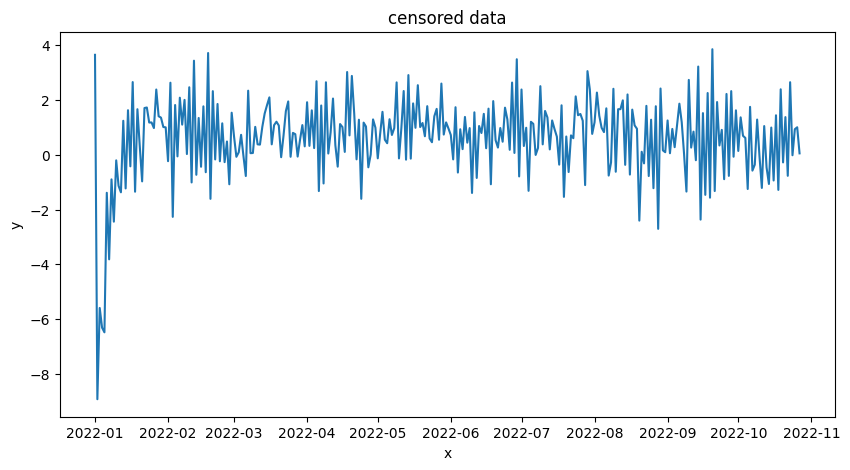

In [15]:
# プロット (疑似的にX軸を作成)
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(pd.date_range(start="2022-01-01", periods=N), Yt)
ax.set(xlabel="x", ylabel="y")
ax.set(title="censored data")

## 実装

In [16]:
# モデル読み込み
model = CmdStanModel(stan_file="../src/stan/ARmodel.stan")

# モデル式
print("-------------------")
model.format()

-------------------
data {
  int<lower=0> K;
  int<lower=0> N;
  array[N] real y;
}
parameters {
  real alpha;
  array[K] real beta;
  real sigma;
}
model {
  for (n in (K + 1) : N) {
    real mu = alpha;
    for (k in 1 : K) {
      mu += beta[k] * y[n - k];
    }
    y[n] ~ normal(mu, sigma);
  }
}




In [17]:
# Data dict for stan
stan_data = {
    "K": K,
    "N": N,
    "y": Yt,
}

# 計算
res = model.sample(
    data=stan_data,
    iter_warmup=1500,
    iter_sampling=500,
    parallel_chains=4,
    chains=4,
)

19:30:56 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:30:57 - cmdstanpy - INFO - CmdStan done processing.


array([[<Axes: title={'center': 'alpha'}>,
        <Axes: title={'center': 'alpha'}>],
       [<Axes: title={'center': 'beta'}>,
        <Axes: title={'center': 'beta'}>],
       [<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>]], dtype=object)

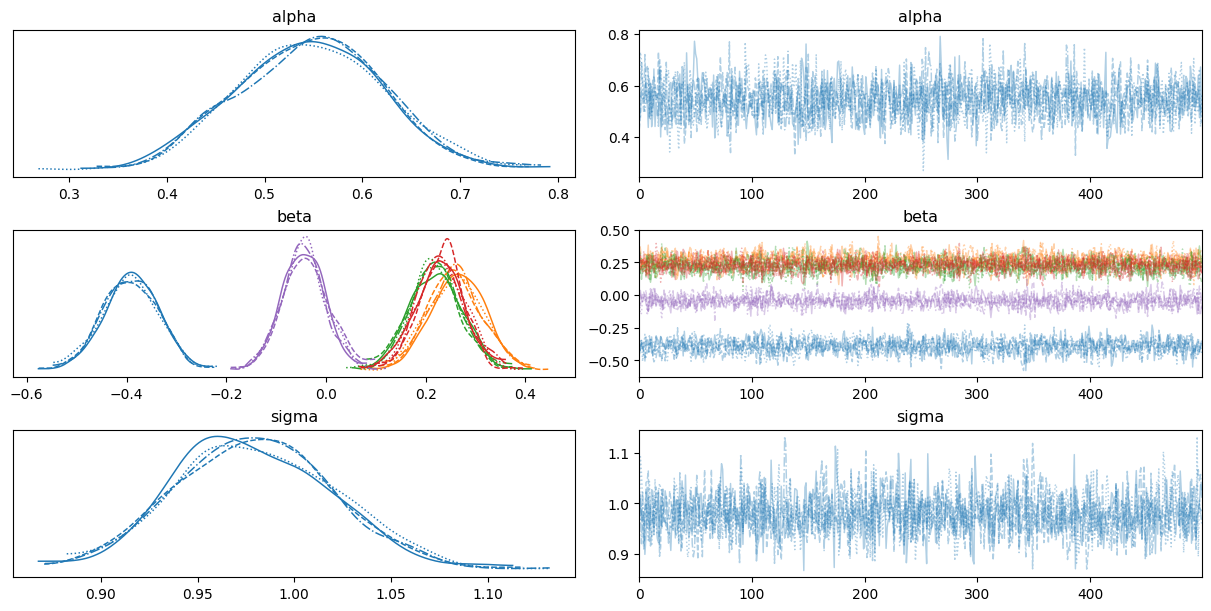

In [18]:
arviz.plot_trace(res, backend_kwargs={"constrained_layout": True})

## 状態空間モデル

### 参考
https://github.com/sinhrks/stan-statespace

In [25]:
# data generating
K, T, d = 4, 1500, 1
X_beta = np.array([1.5, 0.2, -1.2, -0.4])
mu_beta = np.array([1.0])
y_beta = 0.05
s_W, s_v = 1, 2


mu = rg.uniform(-10, 10, d)
X = rg.uniform(-10, 10, (T, K))
Yt = [5]

for i in range(T):
    # 観測
    Yt.append(np.dot(mu, mu_beta) + np.dot(X[i], X_beta) + Yt[i] * y_beta + rg.normal(scale=s_v))
    # 隠れ変数
    mu += rg.normal(scale=s_W, size= d)

Yt = Yt[1:]

[Text(0.5, 1.0, 'state space simulation data')]

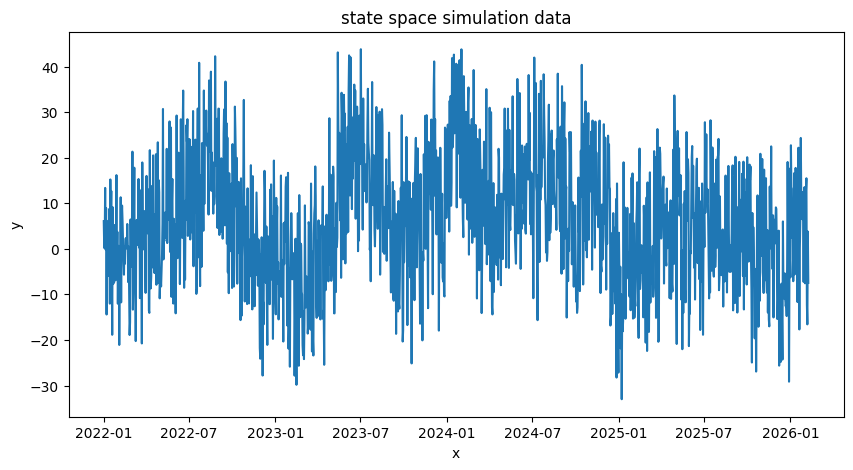

In [26]:
# プロット (疑似的にX軸を作成)
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(pd.date_range(start="2022-01-01", periods=T), Yt)
ax.set(xlabel="x", ylabel="y")
ax.set(title="state space simulation data")

## 実装

In [27]:
# モデル読み込み
model = CmdStanModel(stan_file="../src/stan/StateSpace.stan")

In [28]:
# Data dict for stan
stan_data = {
    "K": K,
    "T": T,
    #"d" : d,
    "y": Yt,
    "X" : X
}

# 計算
res = model.sample(
    data=stan_data,
    iter_warmup=2500,
    iter_sampling=500,
    parallel_chains=4,
    chains=4
)

19:32:01 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

array([[<Axes: title={'center': 'X_beta'}>,
        <Axes: title={'center': 'X_beta'}>],
       [<Axes: title={'center': 'mu_beta'}>,
        <Axes: title={'center': 'mu_beta'}>],
       [<Axes: title={'center': 's_v'}>, <Axes: title={'center': 's_v'}>]],
      dtype=object)

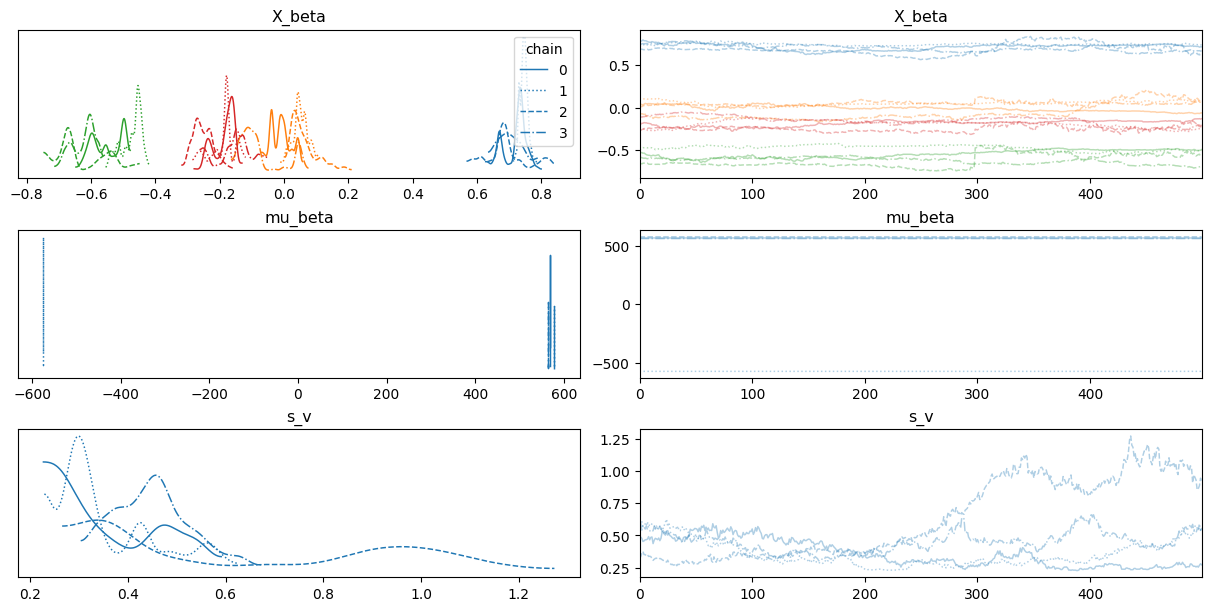

In [ ]:
arviz.plot_trace(
    res, 
    var_names=["~mu", "~s_W"],
    legend = True, 
    divergences=None,
    backend_kwargs={"constrained_layout": True},
    )

In [ ]:
print(res.diagnose())

Processing csv files: /tmp/tmpmgig7fkf/StateSpace7hxg2rnr/StateSpace-20230702193059_1.csv, /tmp/tmpmgig7fkf/StateSpace7hxg2rnr/StateSpace-20230702193059_2.csv, /tmp/tmpmgig7fkf/StateSpace7hxg2rnr/StateSpace-20230702193059_3.csv, /tmp/tmpmgig7fkf/StateSpace7hxg2rnr/StateSpace-20230702193059_4.csv

Checking sampler transitions treedepth.
Treedepth satisfactory for all transitions.

Checking sampler transitions for divergences.
26 of 2000 (1.30%) transitions ended with a divergence.
These divergent transitions indicate that HMC is not fully able to explore the posterior distribution.
Try increasing adapt delta closer to 1.
If this doesn't remove all divergences, try to reparameterize the model.

Checking E-BFMI - sampler transitions HMC potential energy.
The E-BFMI, 0.01, is below the nominal threshold of 0.30 which suggests that HMC may have trouble exploring the target distribution.
If possible, try to reparameterize the model.

Effective sample size satisfactory.

The following paramet